# Analytics Goal: Review Features Across Category

In [1]:
%%configure -f
{
    "conf": {
        "spark.pyspark.python": "python3",
        "spark.pyspark.virtualenv.enabled": "true",
        "spark.pyspark.virtualenv.type": "native",
        "spark.pyspark.virtualenv.bin.path": "/usr/bin/virtualenv",
        "spark.app.name": "msds694",
        "spark.driver.memory": "8G",
        "spark.executor.memory": "4G",
        "sprak.executor.cores": "8"
    }
}

In [6]:
sc.install_pypi_package("plotly")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
86,application_1638590815625_0087,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached https://files.pythonhosted.org/packages/c3/93/54aba8840f511c625937c77dfe5d496aa38371412da07e7a08e6c40094c7/plotly-5.4.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/f2/a5/f86bc8d67c979020438c8559cc70cfe3a1643fd160d35e09c9cca6a09189/tenacity-8.0.1-py3-none-any.whl

In [1]:
import time
start = time.time()

data_path = "s3://msds694-project-zhipeng/data"
rdd = sc.textFile(data_path)
header = rdd.take(1)
rdd = rdd.filter(lambda x: x != header[0])
rdd = rdd.map(lambda x: x.split('\t'))
rdd.cache()

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
105,application_1638590815625_0106,pyspark,idle,,,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

PythonRDD[3] at RDD at PythonRDD.scala:53

In [2]:
# caculate average star_rating for each category
star_rating = rdd.map(lambda x: (x[6], int(x[7])))
sum_rating = star_rating.reduceByKey(lambda x, y: x + y)
sum_rating = sum_rating.sortBy(lambda x: x[0])
sum_rating.toDF().createOrReplaceTempView("sum_rating_view")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
%%sql -o sum_rating
SELECT * FROM sum_rating_view

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Output()

In [4]:
count_rating = star_rating.countByKey()
count_rating = sorted(count_rating.items(), key=lambda x: x[0], reverse=False)
count_rating = sc.parallelize(count_rating)
count_rating.collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[('Digital_Ebook_Purchase', 5101693), ('Digital_Music_Purchase', 1688884), ('Digital_Software', 102084), ('Digital_Video_Download', 4057147), ('Digital_Video_Games', 145431)]

In [5]:
count_rating = count_rating.toDF()
count_rating.createOrReplaceTempView("count_rating_view")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
%%sql -o count_rating
SELECT * FROM count_rating_view

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Output()

In [7]:
%%local
count_rating = count_rating.sort_values(by=['_2'])
count_rating

Output()

In [8]:
%%local
star_rate = count_rating
star_rate['_2'] = sum_rating['_2'] / count_rating['_2']
star_rate = star_rate.sort_values(by=['_2'])
star_rate

Output()

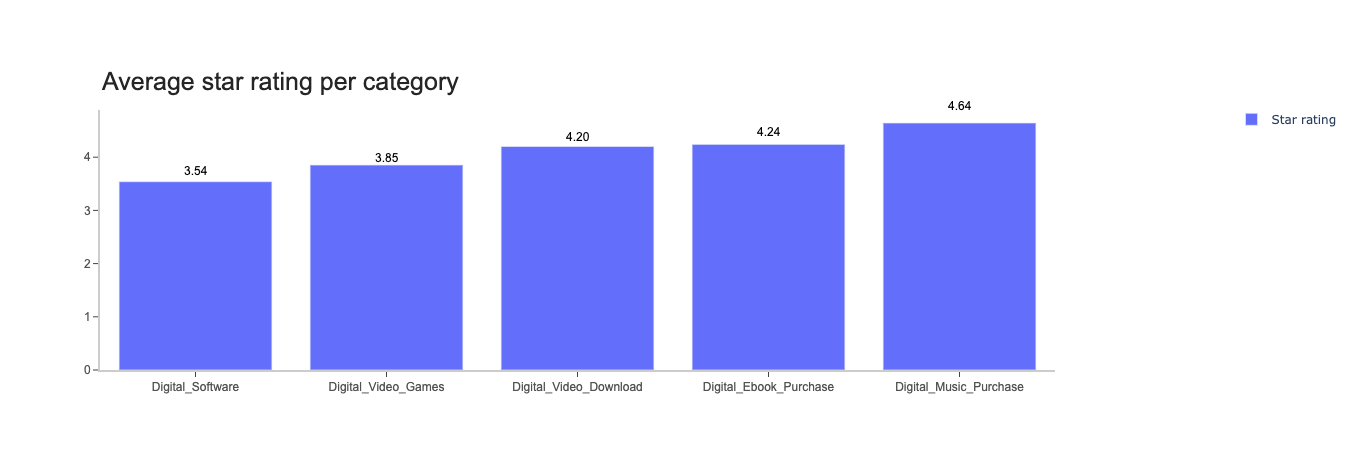

In [9]:
%%local
import plotly
import plotly.graph_objects as go

x = star_rate['_1']
y = star_rate['_2']
fig = go.Figure(data=[go.Bar(x=x, y=y, hovertext=x, name='Star rating')])

#fig.add_trace(go.Bar(x=x, y=y, name='Average Star rating'))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=False,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=12,
            color='rgb(82, 82, 82)',
        ),
    ),
    yaxis=dict(
        showline=True,
        showgrid=False,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=12,
            color='rgb(82, 82, 82)',
        ),
    ),
    autosize=False,
    margin=dict(
        autoexpand=True,
        l=100,
        r=20,
        t=110,
    ),
    showlegend=True,
    plot_bgcolor='white'
)
annotations = []

#annotation
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Average star rating per category',
                              font=dict(family='Arial',
                                        size=25,
                                        color='rgb(37,37,37)'),
                              showarrow=False))


annotations.append(dict(xref='paper', yref='paper', x=0.9, y=1.05,
                              xanchor='center', yanchor='top',
                              text='4.64',
                              font=dict(family='Arial',
                                        size=12,
                                        color='black'),
                              showarrow=False))
annotations.append(dict(xref='paper', yref='paper', x=0.7, y=0.95,
                              xanchor='center', yanchor='top',
                              text='4.24',
                              font=dict(family='Arial',
                                        size=12,
                                        color='black'),
                              showarrow=False))
annotations.append(dict(xref='paper', yref='paper', x=0.5, y=0.93,
                              xanchor='center', yanchor='top',
                              text='4.20',
                              font=dict(family='Arial',
                                        size=12,
                                        color='black'),
                              showarrow=False))
annotations.append(dict(xref='paper', yref='paper', x=0.3, y=0.85,
                              xanchor='center', yanchor='top',
                              text='3.85',
                              font=dict(family='Arial',
                                        size=12,
                                        color='black'),
                              showarrow=False))
annotations.append(dict(xref='paper', yref='paper', x=0.1, y=0.8,
                              xanchor='center', yanchor='top',
                              text='3.54',
                              font=dict(family='Arial',
                                        size=12,
                                        color='black'),
                              showarrow=False))
# Legend
fig.update_layout(legend=dict(
    orientation="v",
    yanchor="top",
    y=1.02,
    xanchor="right",
    x=1.3
))

fig.update_layout(annotations=annotations)
fig.show()

In [10]:
# see the relationship between helpful_vote and rating
helpful_vote = rdd.map(lambda x: (int(x[7]), int(x[8])))
helpful_vote = helpful_vote.reduceByKey(lambda x, y: x + y)
helpful_vote = helpful_vote.sortBy(lambda x: x[0])
helpful_vote.toDF().createOrReplaceTempView("helpful_vote_view")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
helpful_vote_count = rdd.map(lambda x: (int(x[7]), int(x[8])))
count_per_star = helpful_vote_count.countByKey()
count_per_star = sorted(count_per_star.items(),
                        key=lambda x: x[0],
                        reverse=False)
count_per_star = sc.parallelize(count_per_star)
count_per_star = count_per_star.toDF()
count_per_star.createOrReplaceTempView("count_per_star_view")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
%%sql -o helpful_vote
SELECT * FROM helpful_vote_view

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Output()

In [ ]:
%%sql -o count_per_star
SELECT * FROM count_per_star_view

In [14]:
%%local
helpful_pro = count_per_star
helpful_pro['_2'] = helpful_vote['_2'] / count_per_star['_2']
helpful_pro

Output()

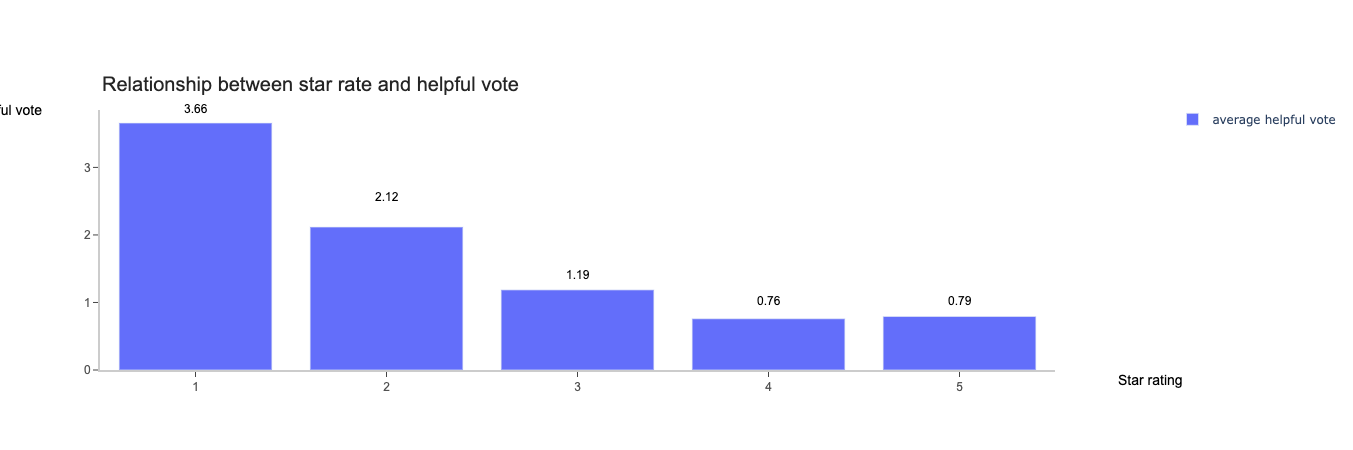

In [15]:
%%local
import plotly
import plotly.graph_objects as go

x = helpful_pro['_1']
y = helpful_pro['_2']
fig = go.Figure(data=[go.Bar(x=x, y=y, hovertext=x, name='average helpful vote')])

#fig.add_trace(go.Bar(x=x, y=y, name='Average Star rating'))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=False,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=12,
            color='rgb(82, 82, 82)',
        ),
    ),
    yaxis=dict(
        showline=True,
        showgrid=False,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=12,
            color='rgb(82, 82, 82)',
        ),
    ),
    autosize=False,
    margin=dict(
        autoexpand=True,
        l=100,
        r=20,
        t=110,
    ),
    showlegend=True,
    plot_bgcolor='white'
)
annotations = []

#annotation
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Relationship between star rate and helpful vote',
                              font=dict(family='Arial',
                                        size=20,
                                        color='rgb(37,37,37)'),
                              showarrow=False))


annotations.append(dict(xref='paper', yref='paper', x=0.9, y=0.3,
                              xanchor='center', yanchor='top',
                              text='0.79',
                              font=dict(family='Arial',
                                        size=12,
                                        color='black'),
                              showarrow=False))
annotations.append(dict(xref='paper', yref='paper', x=0.7, y=0.3,
                              xanchor='center', yanchor='top',
                              text='0.76',
                              font=dict(family='Arial',
                                        size=12,
                                        color='black'),
                              showarrow=False))
annotations.append(dict(xref='paper', yref='paper', x=0.5, y=0.4,
                              xanchor='center', yanchor='top',
                              text='1.19',
                              font=dict(family='Arial',
                                        size=12,
                                        color='black'),
                              showarrow=False))
annotations.append(dict(xref='paper', yref='paper', x=0.3, y=0.7,
                              xanchor='center', yanchor='top',
                              text='2.12',
                              font=dict(family='Arial',
                                        size=12,
                                        color='black'),
                              showarrow=False))
annotations.append(dict(xref='paper', yref='paper', x=0.1, y=1.04,
                              xanchor='center', yanchor='top',
                              text='3.66',
                              font=dict(family='Arial',
                                        size=12,
                                        color='black'),
                              showarrow=False))

annotations.append(dict(xref='paper', yref='paper', x=1.10, y=0.00,
                              xanchor='center', yanchor='top',
                              text='Star rating',
                              font=dict(family='Arial',
                                        size=14,
                                        color='black'),
                              showarrow=False))
annotations.append(dict(xref='paper', yref='paper', x=-0.1, y=1.04,
                              xanchor='center', yanchor='top',
                              text='Helpful vote',
                              font=dict(family='Arial',
                                        size=14,
                                        color='black'),
                              showarrow=False))
# Legend
fig.update_layout(legend=dict(
    orientation="v",
    yanchor="top",
    y=1.02,
    xanchor="right",
    x=1.3
))

fig.update_layout(annotations=annotations)
fig.show()

In [16]:
# Review with star rating above 4 stars accounted for 80%, but they only get around 0.75-0.79 helfpul vote on average. It does not mean they are wrong reviews, 
# probably the products they bought are realy good, but people trend to regard the review pointing out the shortcomings of the products as more helpful.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
%%local
count_per_star['_2'] = (count_per_star['_2'] / count_per_star['_2'].sum())
count_per_star

In [ ]:
%%local
import plotly
import plotly.graph_objects as go

colors = ['gold', 'mediumturquoise', 'darkorange', 'lightgreen']
x = count_per_star['_1']
y = count_per_star['_2']
fig = go.Figure(data=[go.Pie(labels=x, values=y)])
fig.update_traces(hoverinfo='label+percent', textinfo='percent', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.3, y=1.2,
                              xanchor='left', yanchor='bottom',
                              text='Percentage of each star ratings',
                              font=dict(family='Arial',
                                        size=25,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
fig.update_layout(legend=dict(
    orientation="v",
    yanchor="top",
    y=1.02,
    xanchor="right",
    x=0.8
))

fig.update_layout(annotations=annotations)

fig.show()

In [19]:
# check the star_rating differences between different kinds of verified purchase
star_verified = rdd.map(lambda x: (x[11], int(x[7])))
star_verified = star_verified.reduceByKey(lambda x, y: x + y)
star_verified = star_verified.sortBy(lambda x: x[0])
star_verified.toDF().createOrReplaceTempView("star_verified_view")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
verified_count = rdd.map(lambda x: (x[11], int(x[7])))
verified_count = verified_count.countByKey()
verified_count = sorted(verified_count.items(),
                        key=lambda x: x[0],
                        reverse=False)
verified_count = sc.parallelize(verified_count)
verified_count = verified_count.toDF()
verified_count.createOrReplaceTempView("verified_count_view")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
%%sql -o star_verified
SELECT * FROM star_verified_view

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Output()

In [22]:
%%sql -o verified_count
SELECT * FROM verified_count_view

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Output()

In [23]:
%%local
starPerverified = verified_count
starPerverified['_2'] = star_verified['_2'] / verified_count['_2']
starPerverified

Output()

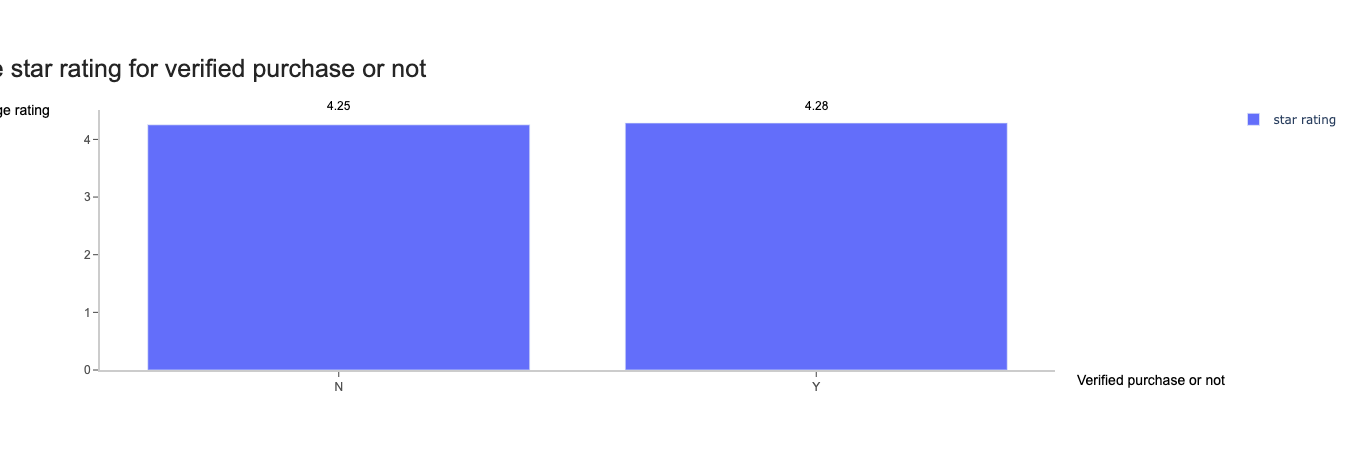

In [24]:
%%local
import plotly
import plotly.graph_objects as go

x = starPerverified['_1']
y = starPerverified['_2']
fig = go.Figure(data=[go.Bar(x=x, y=y, hovertext=x, name='star rating')])

#fig.add_trace(go.Bar(x=x, y=y, name='Average Star rating'))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=False,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=12,
            color='rgb(82, 82, 82)',
        ),
    ),
    yaxis=dict(
        showline=True,
        showgrid=False,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=12,
            color='rgb(82, 82, 82)',
        ),
    ),
    autosize=False,
    margin=dict(
        autoexpand=True,
        l=100,
        r=20,
        t=110,
    ),
    showlegend=True,
    plot_bgcolor='white'
)
annotations = []

#annotation
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=-0.2, y=1.1,
                              xanchor='left', yanchor='bottom',
                              text='Average star rating for verified purchase or not',
                              font=dict(family='Arial',
                                        size=25,
                                        color='rgb(37,37,37)'),
                              showarrow=False))


annotations.append(dict(xref='paper', yref='paper', x=0.75, y=1.05,
                              xanchor='center', yanchor='top',
                              text='4.28',
                              font=dict(family='Arial',
                                        size=12,
                                        color='black'),
                              showarrow=False))
annotations.append(dict(xref='paper', yref='paper', x=0.25, y=1.05,
                              xanchor='center', yanchor='top',
                              text='4.25',
                              font=dict(family='Arial',
                                        size=12,
                                        color='black'),
                              showarrow=False))
annotations.append(dict(xref='paper', yref='paper', x=1.10, y=0.00,
                              xanchor='center', yanchor='top',
                              text='Verified purchase or not',
                              font=dict(family='Arial',
                                        size=14,
                                        color='black'),
                              showarrow=False))
annotations.append(dict(xref='paper', yref='paper', x=-0.1, y=1.04,
                              xanchor='center', yanchor='top',
                              text='Average rating',
                              font=dict(family='Arial',
                                        size=14,
                                        color='black'),
                              showarrow=False))

# Legend
fig.update_layout(legend=dict(
    orientation="v",
    yanchor="top",
    y=1.02,
    xanchor="right",
    x=1.3
))

fig.update_layout(annotations=annotations)
fig.show()

In [25]:
# check the differences of helpful_vote between different kinds of verified purchase
helpful_vote_verified = rdd.map(lambda x: (x[11], int(x[8])))
helpful_vote_verified = helpful_vote_verified.reduceByKey(lambda x, y: x + y)
helpful_vote_verified = helpful_vote_verified.sortBy(lambda x: x[0])
helpful_vote_verified.toDF().createOrReplaceTempView("helpful_vote_verified_view")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [26]:
%%sql -o helpful_vote_verified
SELECT * FROM helpful_vote_verified_view

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Output()

In [27]:
%%sql -o verified_count
SELECT * FROM verified_count_view

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Output()

In [28]:
%%local
votePerverified = verified_count
votePerverified['_2'] = helpful_vote_verified['_2'] / verified_count['_2']
votePerverified

Output()

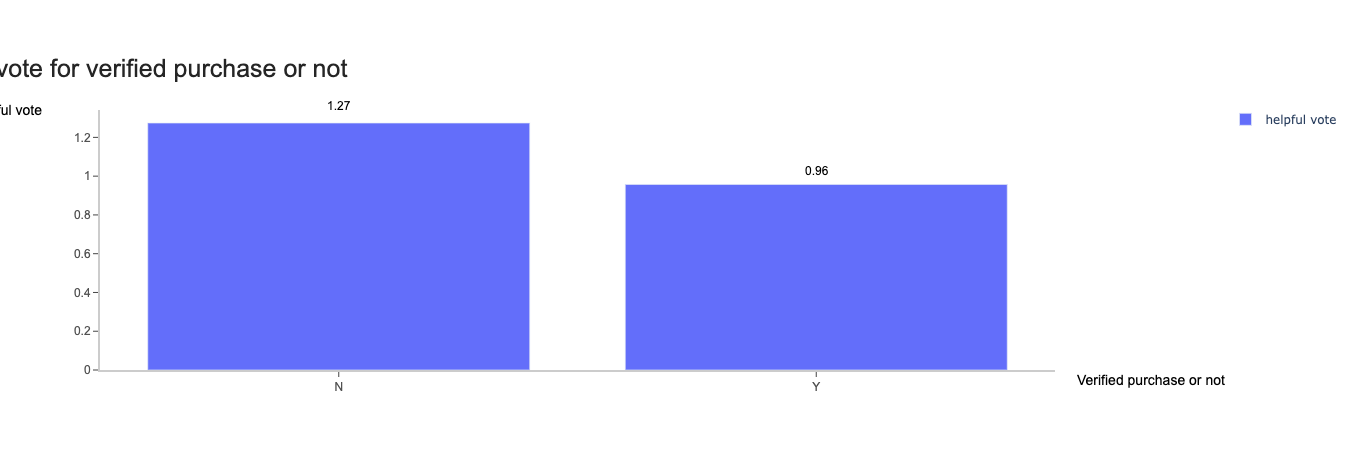

In [29]:
%%local
import plotly
import plotly.graph_objects as go

x = votePerverified['_1']
y = votePerverified['_2']
fig = go.Figure(data=[go.Bar(x=x, y=y, hovertext=x, name='helpful vote')])

#fig.add_trace(go.Bar(x=x, y=y, name='Average Star rating'))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=False,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=12,
            color='rgb(82, 82, 82)',
        ),
    ),
    yaxis=dict(
        showline=True,
        showgrid=False,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=12,
            color='rgb(82, 82, 82)',
        ),
    ),
    autosize=False,
    margin=dict(
        autoexpand=True,
        l=100,
        r=20,
        t=110,
    ),
    showlegend=True,
    plot_bgcolor='white'
)
annotations = []

#annotation
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=-0.2, y=1.1,
                              xanchor='left', yanchor='bottom',
                              text='Helpful vote for verified purchase or not',
                              font=dict(family='Arial',
                                        size=25,
                                        color='rgb(37,37,37)'),
                              showarrow=False))


annotations.append(dict(xref='paper', yref='paper', x=0.75, y=0.8,
                              xanchor='center', yanchor='top',
                              text='0.96',
                              font=dict(family='Arial',
                                        size=12,
                                        color='black'),
                              showarrow=False))
annotations.append(dict(xref='paper', yref='paper', x=0.25, y=1.05,
                              xanchor='center', yanchor='top',
                              text='1.27',
                              font=dict(family='Arial',
                                        size=12,
                                        color='black'),
                              showarrow=False))
annotations.append(dict(xref='paper', yref='paper', x=1.10, y=0.00,
                              xanchor='center', yanchor='top',
                              text='Verified purchase or not',
                              font=dict(family='Arial',
                                        size=14,
                                        color='black'),
                              showarrow=False))
annotations.append(dict(xref='paper', yref='paper', x=-0.1, y=1.04,
                              xanchor='center', yanchor='top',
                              text='Helpful vote',
                              font=dict(family='Arial',
                                        size=14,
                                        color='black'),
                              showarrow=False))

# Legend
fig.update_layout(legend=dict(
    orientation="v",
    yanchor="top",
    y=1.02,
    xanchor="right",
    x=1.3
))

fig.update_layout(annotations=annotations)
fig.show()

In [30]:
print('time used: ', time.time()-start)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

time used:  116.73440146446228